In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images
from utils.Preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer

# Training

In [ ]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "output_base_path" : "./outputs",
    "name" : "Attention7-512capedAug"
}
class_map = {
    0: '1',1: '2', 2: '3',3: '4',
    4: '5',5: '6',6: '7',7: '8',
    8: '9',9: '9a',10: '10',11: '10a',
    12: '11',13: '12',14: '12a',15: '13',
    16: '14',17: '14a',18: '15',19: '16',
    20: '16a',21: '16b',22: '16c',
    23: '12b',24: '14b'
}

In [3]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 25),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [4]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [6]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0) | loss : 1.6100034523010254 
dice loss : -0.011350453281775117 - bce loss : 1.6213539081811905 
train avg dice epoch 0 : 0.0008405553327053067
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0) | loss : 0.6562620133161545 
dice loss : -0.011827009916305541 - bce loss : 0.6680890262126923 
valid avg dice epoch 0 : 4.093689506845001e-13
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1) | loss : 0.35495290890336034 
dice loss : -0.02109417096711695 - bce loss : 0.3760470801591873 
train avg dice epoch 1 : 1.1656822576207058e-07
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1) | loss : 0.22393758967518806 
dice loss : -0.027730171382427216 - bce loss : 0.25166775956749915 
valid avg dice epoch 1 : 4.217896415166858e-13
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2) | loss : 0.15258198879659177 
dice loss : -0.051998771540820596 - bce loss : 0.20458076030015945 
train avg dice epoch 2 : 0.013657941353018198
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2) | loss : 0.10669918283820153 
dice loss : -0.08681056872010232 - bce loss : 0.19350975155830383 
valid avg dice epoch 2 : 0.028324135039409604
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3) | loss : 0.030887312442064285 
dice loss : -0.13787521049380302 - bce loss : 0.1687625229358673 
train avg dice epoch 3 : 0.06402755963660219
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3) | loss : -0.018729127198457717 
dice loss : -0.18648238927125932 - bce loss : 0.16775326207280158 
valid avg dice epoch 3 : 0.08760199517051846
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4) | loss : -0.07876356348395347 
dice loss : -0.2296178251504898 - bce loss : 0.1508542615175247 
train avg dice epoch 4 : 0.10783139437830291
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4) | loss : -0.08544971495866775 
dice loss : -0.2454930476844311 - bce loss : 0.16004333272576332 
valid avg dice epoch 4 : 0.11844060472251718
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5) | loss : -0.1581542841345072 
dice loss : -0.2965045063197613 - bce loss : 0.1383502224087715 
train avg dice epoch 5 : 0.15271573245569348
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5) | loss : -0.15720262378454208 
dice loss : -0.30116351172327993 - bce loss : 0.14396088793873787 
valid avg dice epoch 5 : 0.1745716536048972
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6) | loss : -0.21236228749155997 
dice loss : -0.34372126385569574 - bce loss : 0.1313589758425951 
train avg dice epoch 6 : 0.17720330634896506
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6) | loss : -0.19122444167733194 
dice loss : -0.3316107541322708 - bce loss : 0.1403863128274679 
valid avg dice epoch 6 : 0.18808008930683942
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7) | loss : -0.24541738376021385 
dice loss : -0.3736894130706787 - bce loss : 0.12827202923595904 
train avg dice epoch 7 : 0.1933753373105731
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7) | loss : -0.21004905700683593 
dice loss : -0.3498665690422058 - bce loss : 0.13981751017272473 
valid avg dice epoch 7 : 0.19846088156142147
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8) | loss : -0.27446165442466736 
dice loss : -0.3976098117232323 - bce loss : 0.12314815796911717 
train avg dice epoch 8 : 0.2104562002424803
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8) | loss : -0.23904064074158668 
dice loss : -0.37353835701942445 - bce loss : 0.13449771590530873 
valid avg dice epoch 8 : 0.22191520512142093
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9) | loss : -0.27463876858353614 
dice loss : -0.3998809359967709 - bce loss : 0.12524216823279857 
train avg dice epoch 9 : 0.21008741211451618
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9) | loss : -0.23668045550584793 
dice loss : -0.3719972833991051 - bce loss : 0.1353168275207281 
valid avg dice epoch 9 : 0.21916839718856726
1 => 0.6432752013206482
2 => 0.5420677065849304
3 => 0.6211627721786499
4 => 0.41232722997665405
5 => 0.6573951840400696
6 => 0.4641111195087433
7 => 0.4433741271495819
8 => 0.4283889830112457
9 => 0.19856637716293335
9a => 2.7465735848858364e-13
10 => 5.384739420848106e-13
10a => 2.6413101306826947e-12
11 => 0.42739376425743103
12 => 2.814522974490391e-13
12a => 1.3709333961022668e-13
13 => 0.37314578890800476
14 => 2.4080138382419347e-13
14a => 2.437597378720374e-13
15 => 2.705627605639749e-12
16 => 0.2680016756057739
16a => 7.55344029511329e-13
16b => 4.744958224077445e-13
16c => 7.055171334299781e-13
12b 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10) | loss : -0.3140926292538643 
dice loss : -0.4321655616164207 - bce loss : 0.11807293325662613 
train avg dice epoch 10 : 0.2256837435474111
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10) | loss : -0.2681436978280544 
dice loss : -0.40082715451717377 - bce loss : 0.13268345594406128 
valid avg dice epoch 10 : 0.2350524816572596
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11) | loss : -0.33024097099900246 
dice loss : -0.4460386747121811 - bce loss : 0.11579770371317863 
train avg dice epoch 11 : 0.2330879043239068
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11) | loss : -0.2839921429753304 
dice loss : -0.4071526065468788 - bce loss : 0.12316046766936779 
valid avg dice epoch 11 : 0.24158228903113507
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12) | loss : -0.3423614813387394 
dice loss : -0.4555378279089928 - bce loss : 0.11317634537816047 
train avg dice epoch 12 : 0.23992390405429917
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12) | loss : -0.2985702000558376 
dice loss : -0.424561882019043 - bce loss : 0.1259916815906763 
valid avg dice epoch 12 : 0.25103050991928777
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13) | loss : -0.35035261377692223 
dice loss : -0.462894501388073 - bce loss : 0.11254188805818557 
train avg dice epoch 13 : 0.24614694997711495
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13) | loss : -0.2617372177541256 
dice loss : -0.39971187710762024 - bce loss : 0.13797465860843658 
valid avg dice epoch 13 : 0.2317480782981833
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14) | loss : -0.35750068187713624 
dice loss : -0.4687533047795296 - bce loss : 0.11125262156128883 
train avg dice epoch 14 : 0.25271283850117043
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14) | loss : -0.31552971079945563 
dice loss : -0.43577285706996916 - bce loss : 0.1202431458979845 
valid avg dice epoch 14 : 0.25968706440216505
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15) | loss : -0.3731775699555874 
dice loss : -0.4817496201395988 - bce loss : 0.10857205078005791 
train avg dice epoch 15 : 0.2613651654128566
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15) | loss : -0.304623456299305 
dice loss : -0.4283752292394638 - bce loss : 0.12375177443027496 
valid avg dice epoch 15 : 0.2542265017334243
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16) | loss : -0.37245107457041743 
dice loss : -0.48073359340429306 - bce loss : 0.1082825192809105 
train avg dice epoch 16 : 0.2635922130946668
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16) | loss : -0.3183768689632416 
dice loss : -0.44177690148353577 - bce loss : 0.12340003289282322 
valid avg dice epoch 16 : 0.267980622053506
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17) | loss : -0.3822999942302704 
dice loss : -0.4894409614801407 - bce loss : 0.10714096739888192 
train avg dice epoch 17 : 0.2708456689123662
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17) | loss : -0.3352850630879402 
dice loss : -0.4541199505329132 - bce loss : 0.11883488893508912 
valid avg dice epoch 17 : 0.2788018904629966
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18) | loss : -0.3945410792529583 
dice loss : -0.5004133376479148 - bce loss : 0.10587225750088691 
train avg dice epoch 18 : 0.27586198641728676
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18) | loss : -0.30323401764035224 
dice loss : -0.4279430016875267 - bce loss : 0.12470898553729057 
valid avg dice epoch 18 : 0.2643234343224596
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19) | loss : -0.3962261801958084 
dice loss : -0.501108270585537 - bce loss : 0.1048820922523737 
train avg dice epoch 19 : 0.27665077383206255
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19) | loss : -0.3525524452328682 
dice loss : -0.4662246391177177 - bce loss : 0.11367219425737858 
valid avg dice epoch 19 : 0.29153940799212263
1 => 0.7711873054504395
2 => 0.6481534838676453
3 => 0.668603241443634
4 => 0.502625048160553
5 => 0.7214081287384033
6 => 0.5822522640228271
7 => 0.5735547542572021
8 => 0.5884143710136414
9 => 0.26022839546203613
9a => 0.001546749146655202
10 => 5.384739420848106e-13
10a => 2.6413101306826947e-12
11 => 0.5944740176200867
12 => 2.814522974490391e-13
12a => 0.1539454460144043
13 => 0.4851478934288025
14 => 0.06176578998565674
14a => 2.437597378720374e-13
15 => 2.705627605639749e-12
16 => 0.4728580415248871
16a => 0.00148654670920223
16b => 4.744958224077445e-13
16c => 7.055171334299781e-13
12b => 3.725782432

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20) | loss : -0.41283913016319274 
dice loss : -0.5147613301873207 - bce loss : 0.1019221994280815 
train avg dice epoch 20 : 0.2911175223944638
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20) | loss : -0.3530580051243305 
dice loss : -0.46660236865282056 - bce loss : 0.11354436427354812 
valid avg dice epoch 20 : 0.29338270680078293
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21) | loss : -0.411785834133625 
dice loss : -0.514208502471447 - bce loss : 0.1024226701259613 
train avg dice epoch 21 : 0.29368695484224466
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21) | loss : -0.3640222534537315 
dice loss : -0.4749449446797371 - bce loss : 0.11092269122600555 
valid avg dice epoch 21 : 0.3002828448268863
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22) | loss : -0.4208283919095993 
dice loss : -0.5211388972401619 - bce loss : 0.1003105043247342 
train avg dice epoch 22 : 0.30042146289062743
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22) | loss : -0.36747182309627535 
dice loss : -0.47629357427358626 - bce loss : 0.10882174968719482 
valid avg dice epoch 22 : 0.2997030359200989
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23) | loss : -0.43537908405065534 
dice loss : -0.5340852358937264 - bce loss : 0.09870615176856518 
train avg dice epoch 23 : 0.3071624780409556
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23) | loss : -0.36572263538837435 
dice loss : -0.4749828115105629 - bce loss : 0.1092601738870144 
valid avg dice epoch 23 : 0.3061384713279821
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24) | loss : -0.4354686412215233 
dice loss : -0.5338575240969657 - bce loss : 0.09838888294994831 
train avg dice epoch 24 : 0.31053242888050675
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24) | loss : -0.3702615350484848 
dice loss : -0.478866221010685 - bce loss : 0.10860468223690986 
valid avg dice epoch 24 : 0.3131998133987926
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25) | loss : -0.44159946143627166 
dice loss : -0.5398353344202041 - bce loss : 0.09823587618768215 
train avg dice epoch 25 : 0.3165942500535684
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25) | loss : -0.37873860001564025 
dice loss : -0.48668292760848997 - bce loss : 0.10794432647526264 
valid avg dice epoch 25 : 0.31937697082786776
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26) | loss : -0.4520113694667816 
dice loss : -0.5479663002490998 - bce loss : 0.09595493111759425 
train avg dice epoch 26 : 0.32598141350844856
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26) | loss : -0.3737753704190254 
dice loss : -0.4815340772271156 - bce loss : 0.10775870718061924 
valid avg dice epoch 26 : 0.3203127890082814
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27) | loss : -0.4553325992822647 
dice loss : -0.5509562501311303 - bce loss : 0.09562365122139455 
train avg dice epoch 27 : 0.3297468294021003
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27) | loss : -0.3816524803638458 
dice loss : -0.48858005106449126 - bce loss : 0.10692757368087769 
valid avg dice epoch 27 : 0.3229107772561528
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28) | loss : -0.4547619736194611 
dice loss : -0.5504030784964562 - bce loss : 0.09564110450446606 
train avg dice epoch 28 : 0.3273446809713262
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28) | loss : -0.3886156365275383 
dice loss : -0.4944930449128151 - bce loss : 0.10587740801274777 
valid avg dice epoch 28 : 0.3303702234479405
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29) | loss : -0.45962348222732546 
dice loss : -0.5550135195255279 - bce loss : 0.09539003733545542 
train avg dice epoch 29 : 0.3317130122337782
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29) | loss : -0.3783992439508438 
dice loss : -0.49031958878040316 - bce loss : 0.11192034631967544 
valid avg dice epoch 29 : 0.3245255824367321
1 => 0.7304675579071045
2 => 0.6531242728233337
3 => 0.680389404296875
4 => 0.5170837044715881
5 => 0.7540497183799744
6 => 0.5729883909225464
7 => 0.6098156571388245
8 => 0.6621289849281311
9 => 0.2753483057022095
9a => 0.12261663377285004
10 => 5.384739420848106e-13
10a => 2.6413101306826947e-12
11 => 0.6294154524803162
12 => 0.08111431449651718
12a => 0.20244941115379333
13 => 0.5275598764419556
14 => 0.144338458776474
14a => 2.437597378720374e-13
15 => 2.705627605639749e-12
16 => 0.43499553203582764
16a => 0.019147710874676704
16b => 0.19469381868839264
16c => 0.00652925344184041
12b => 3.6934442049912

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


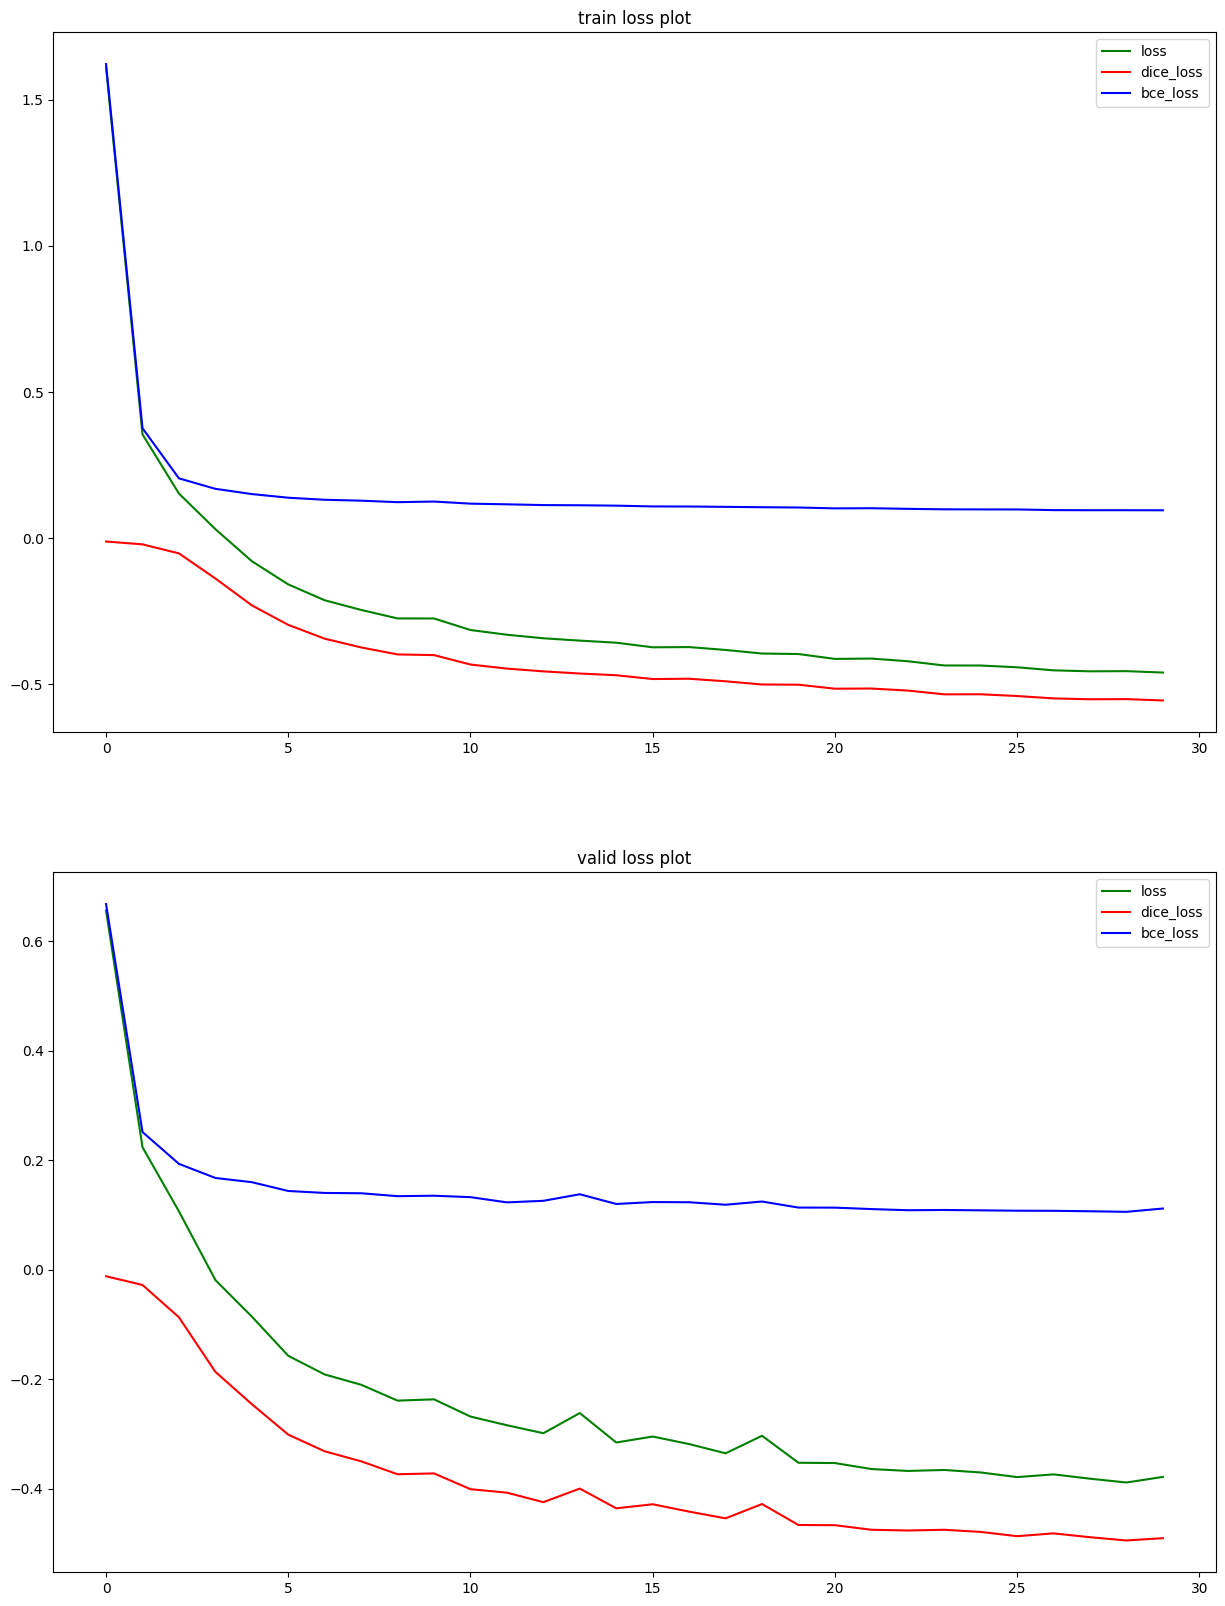

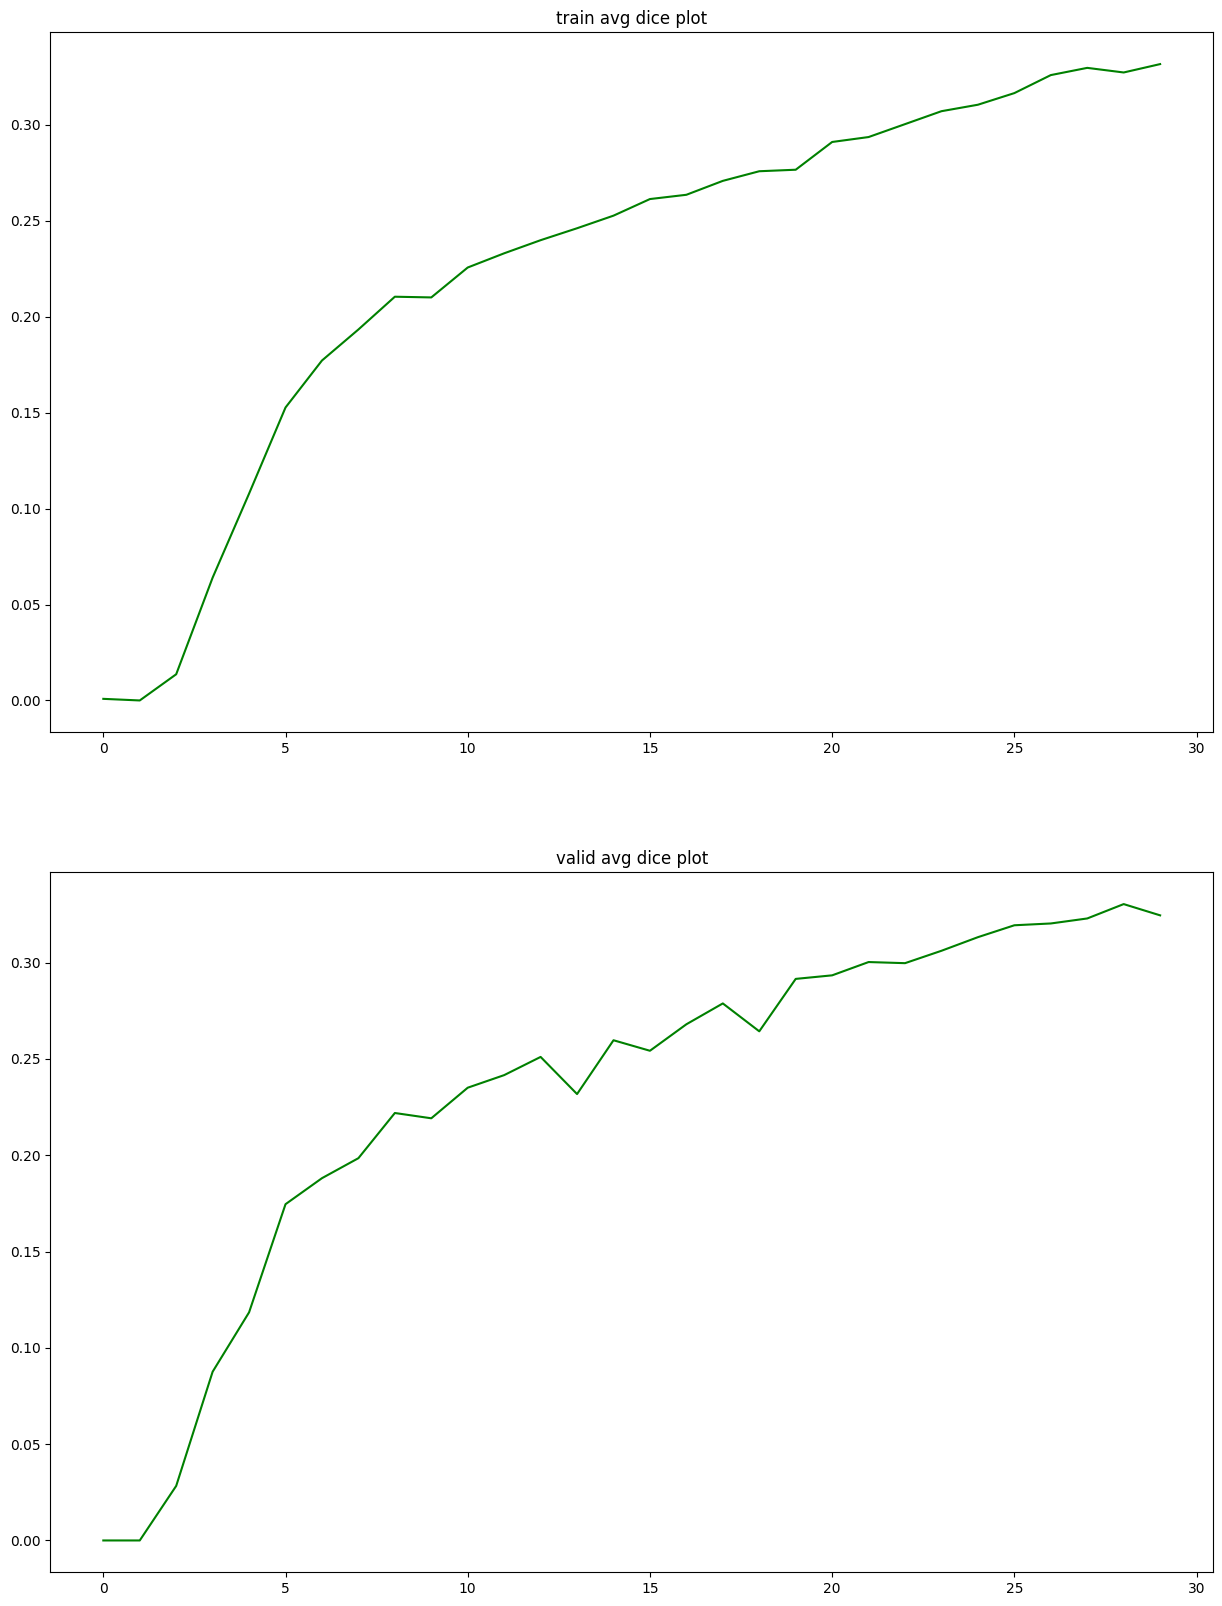

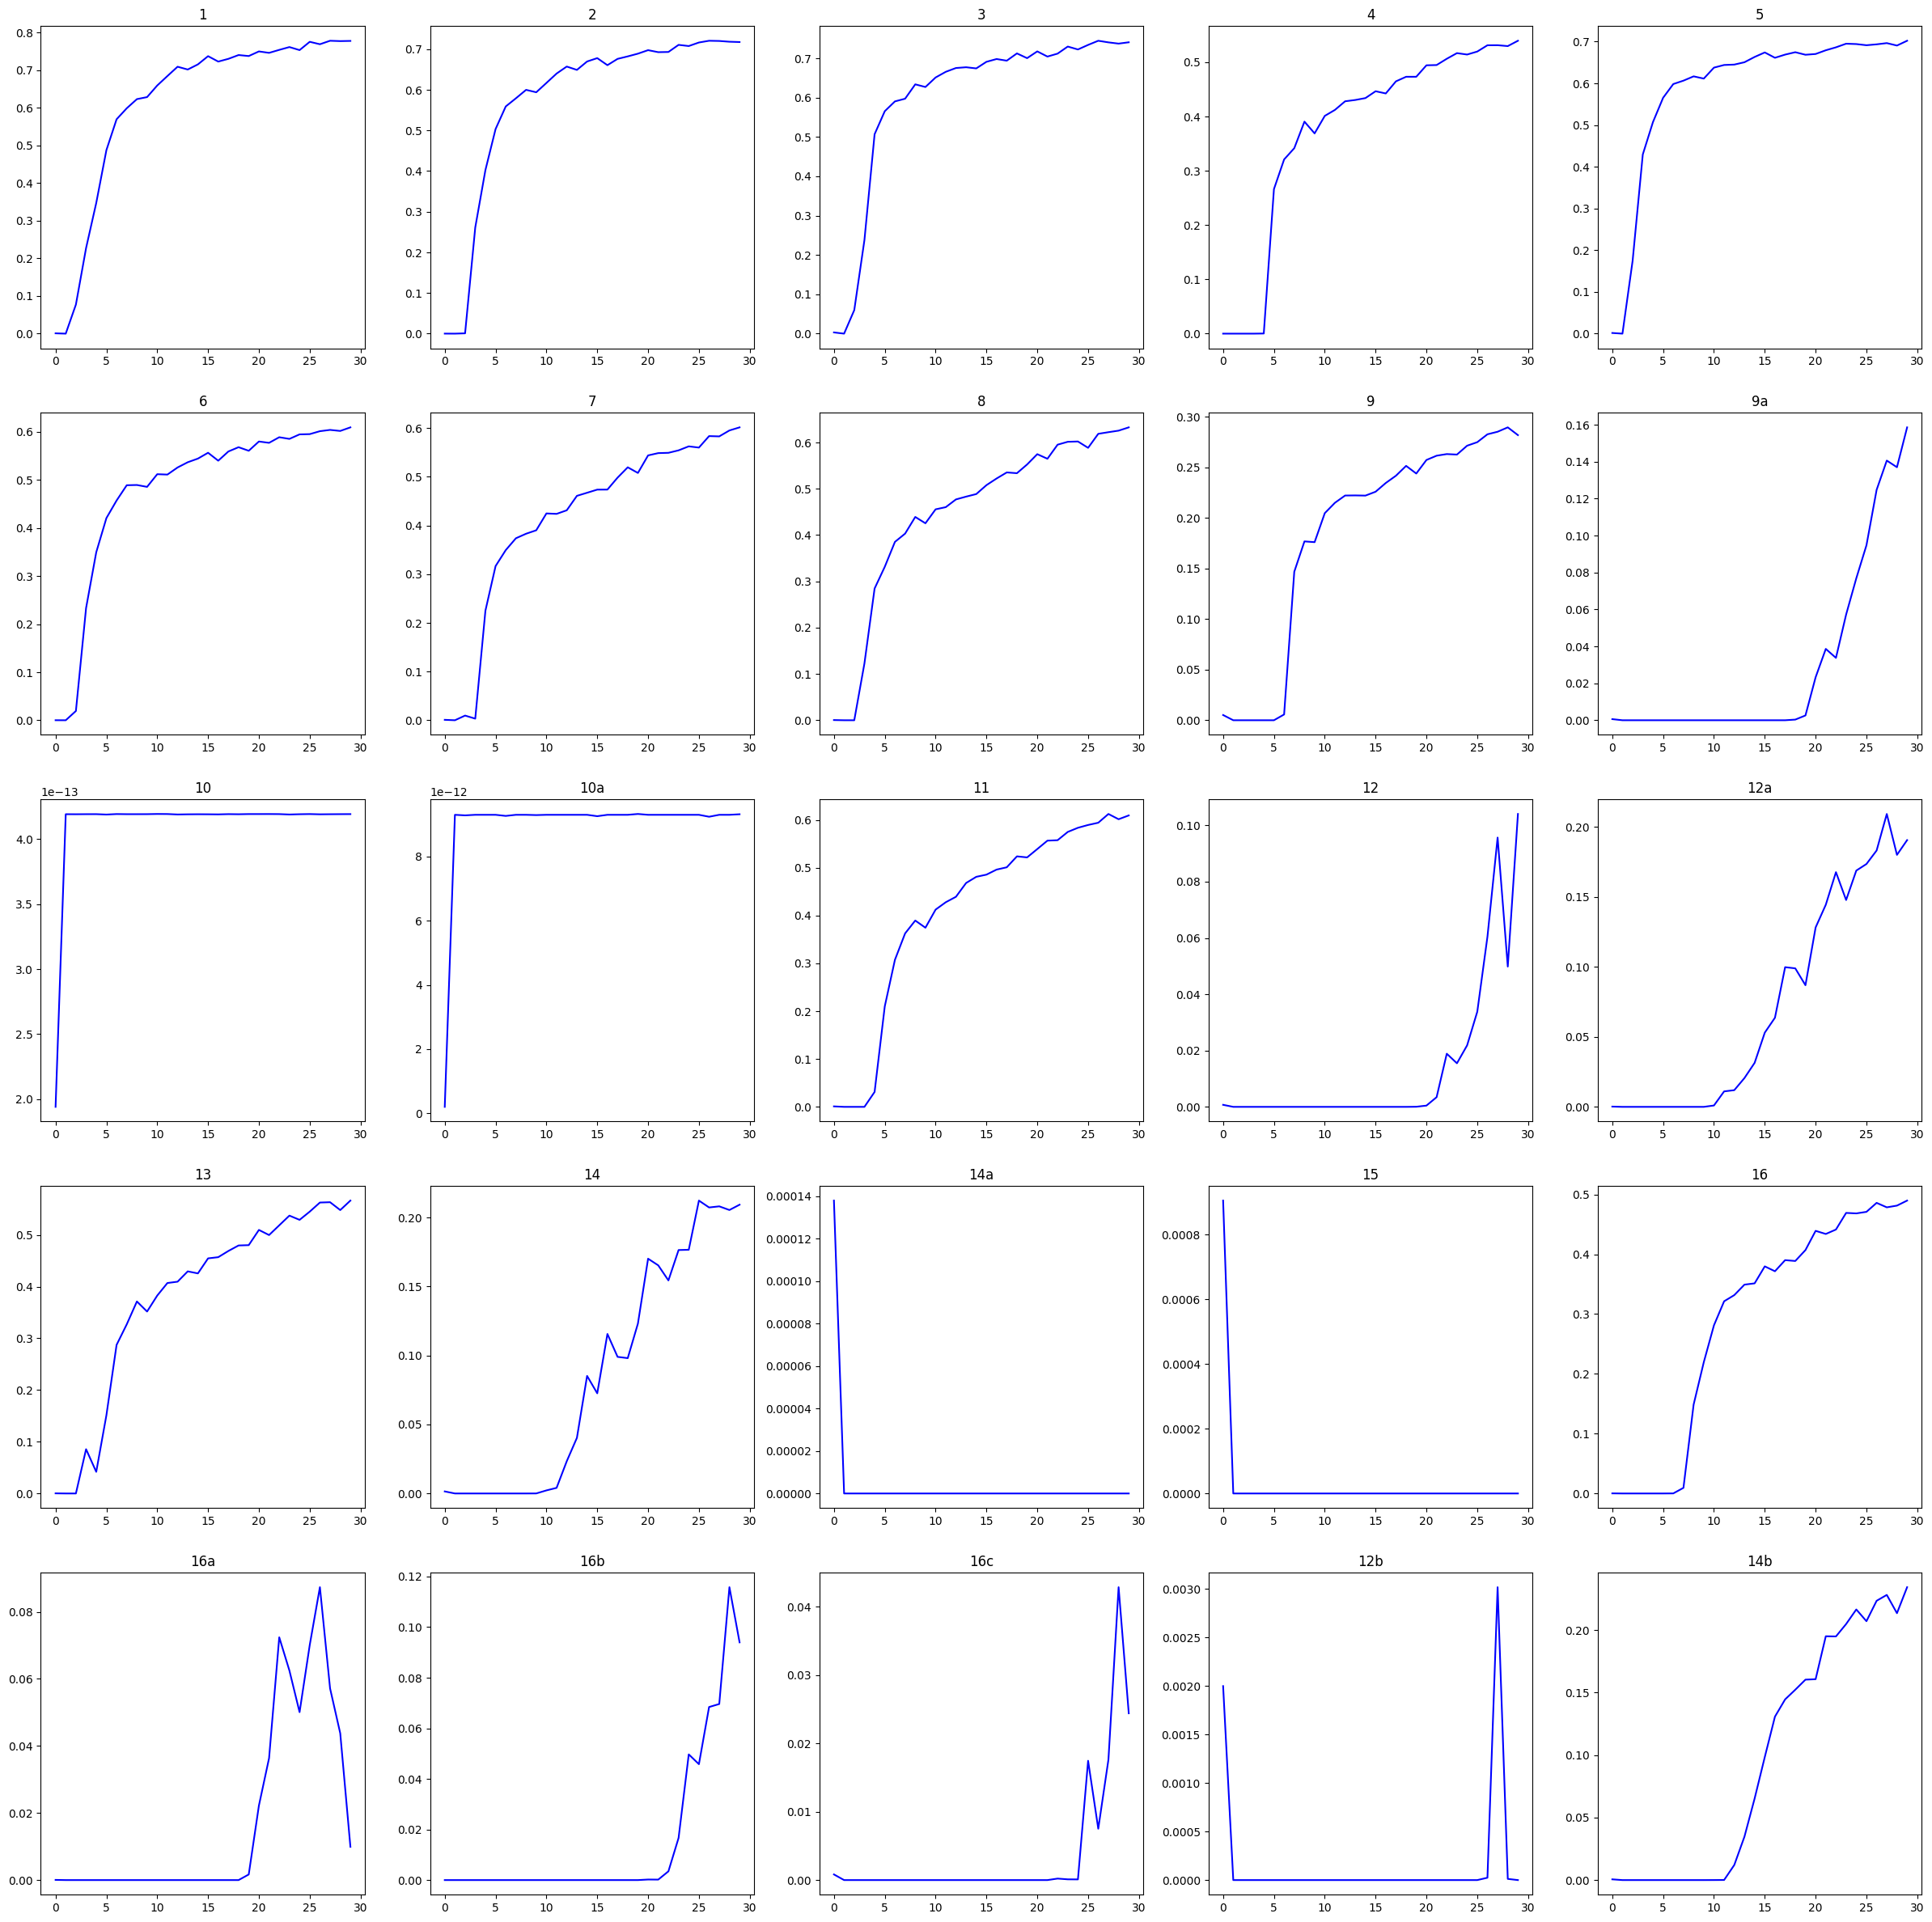

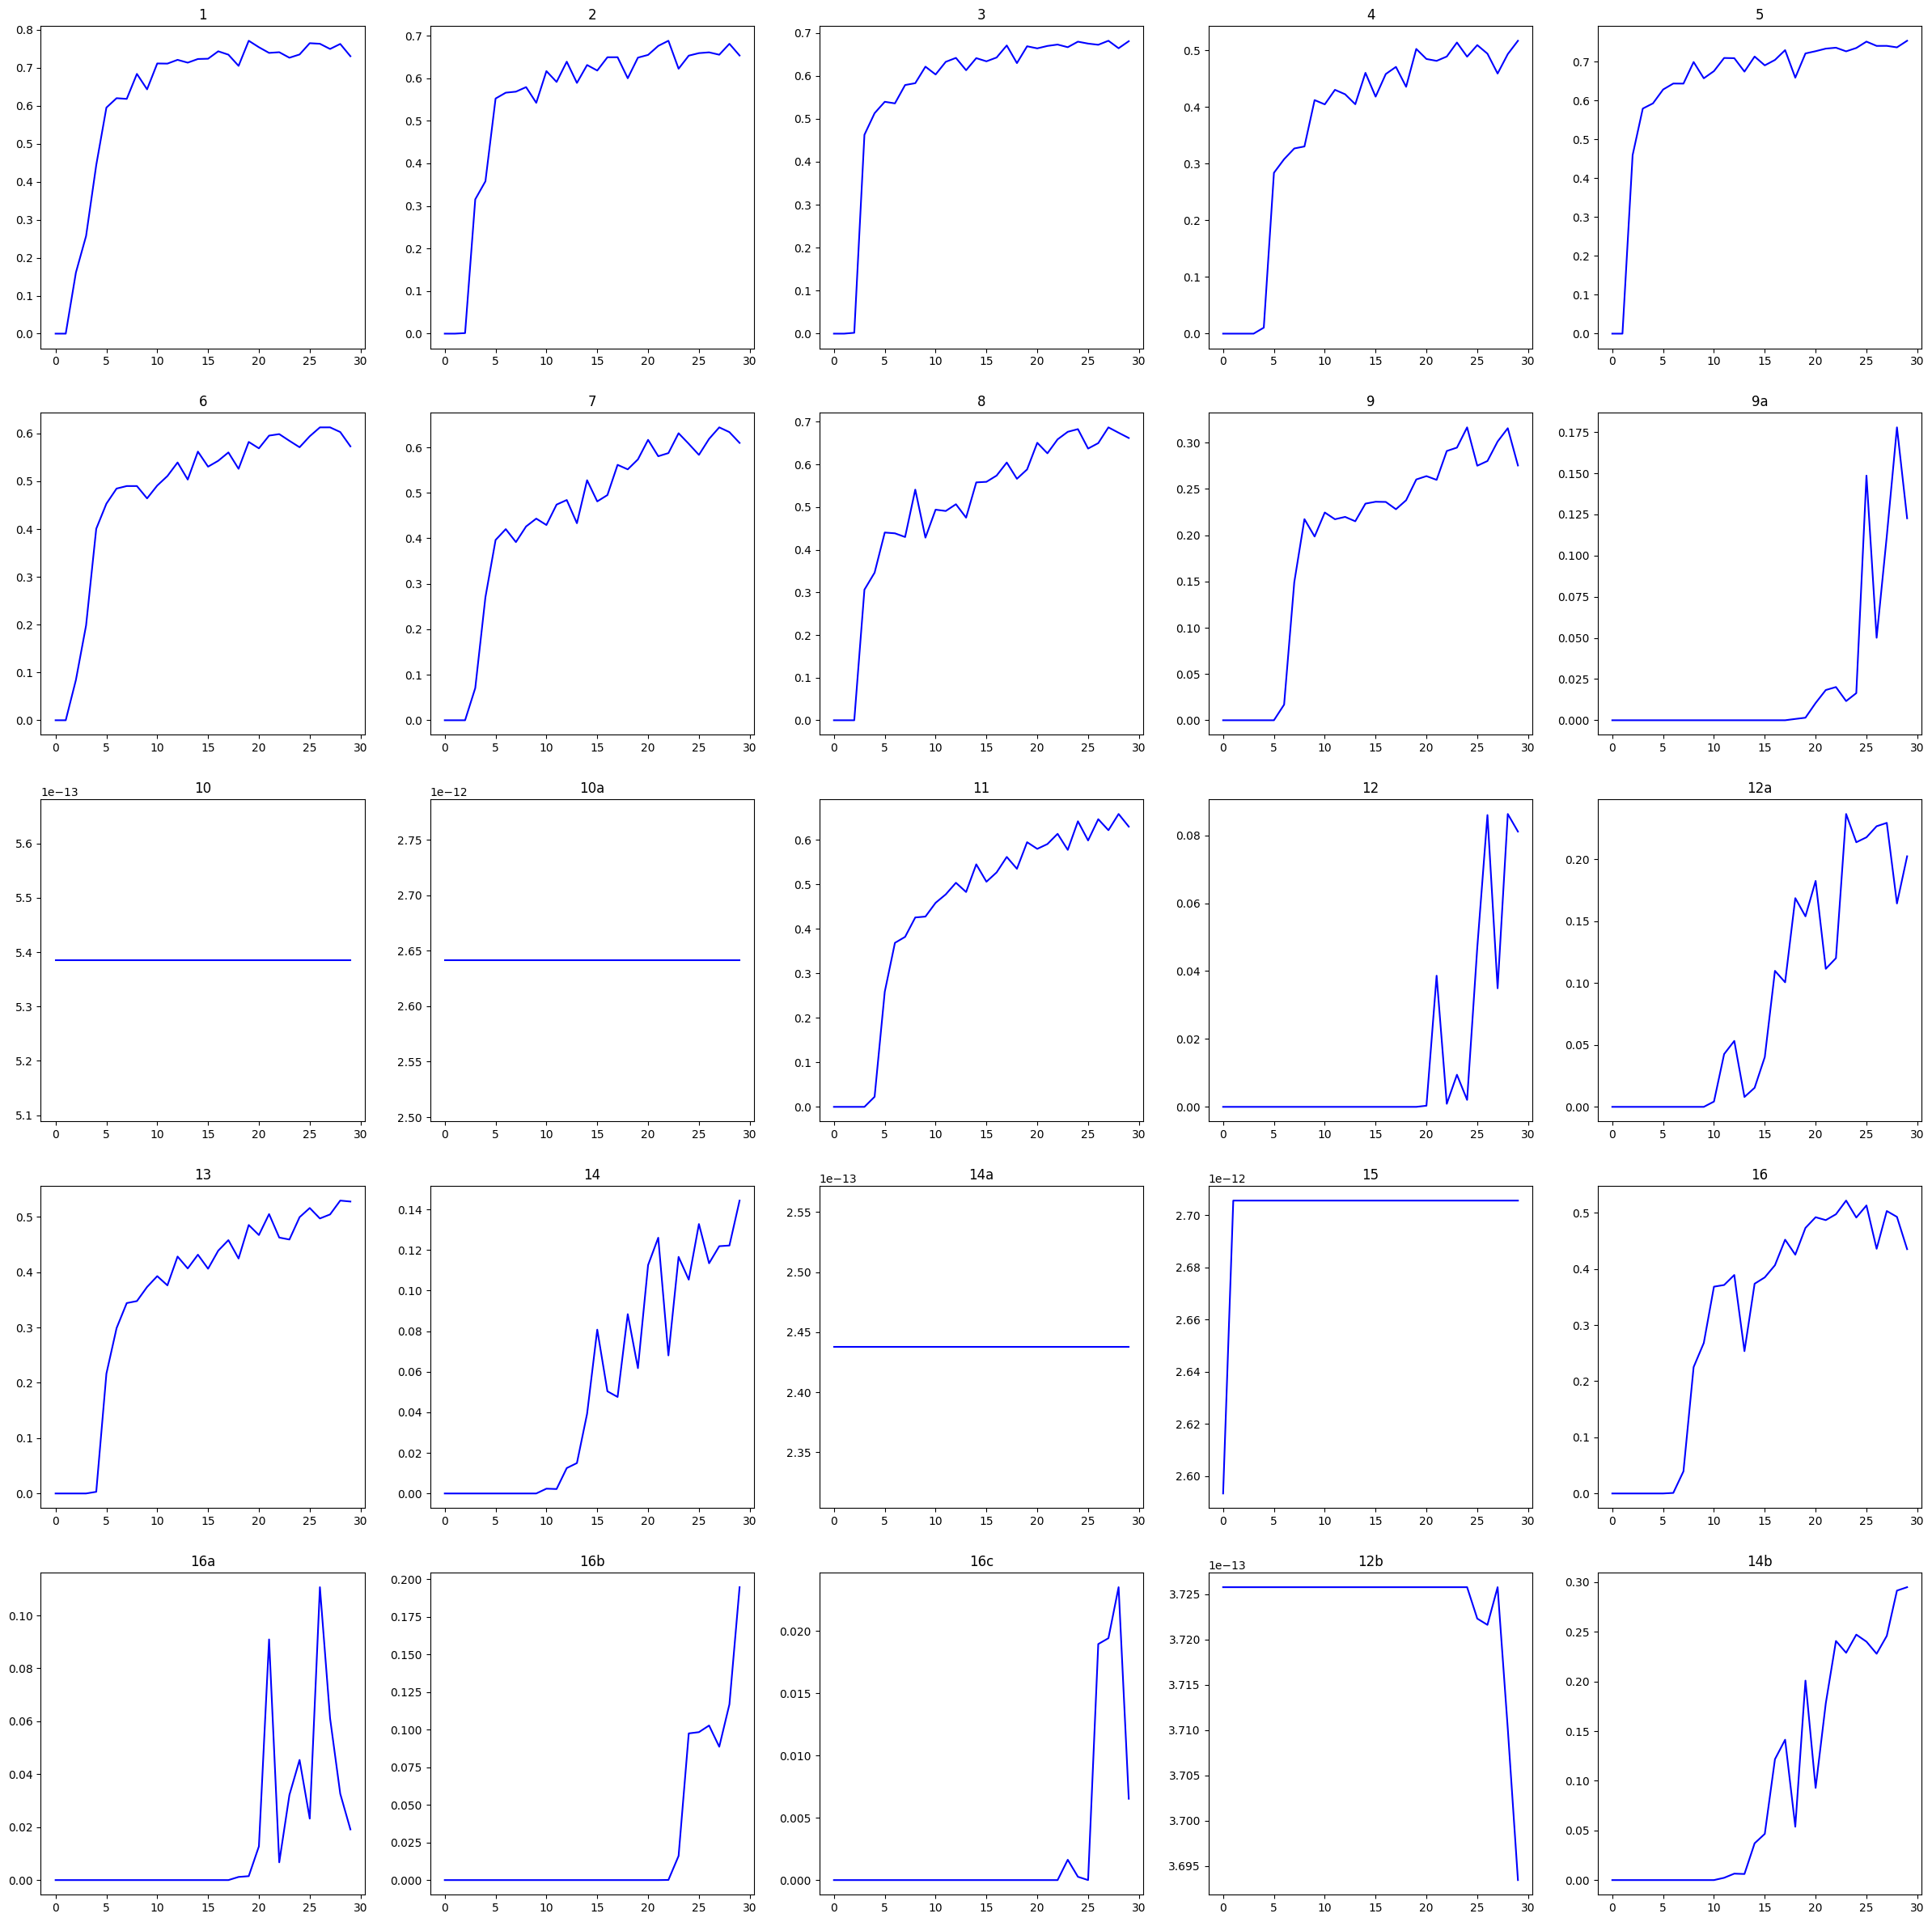

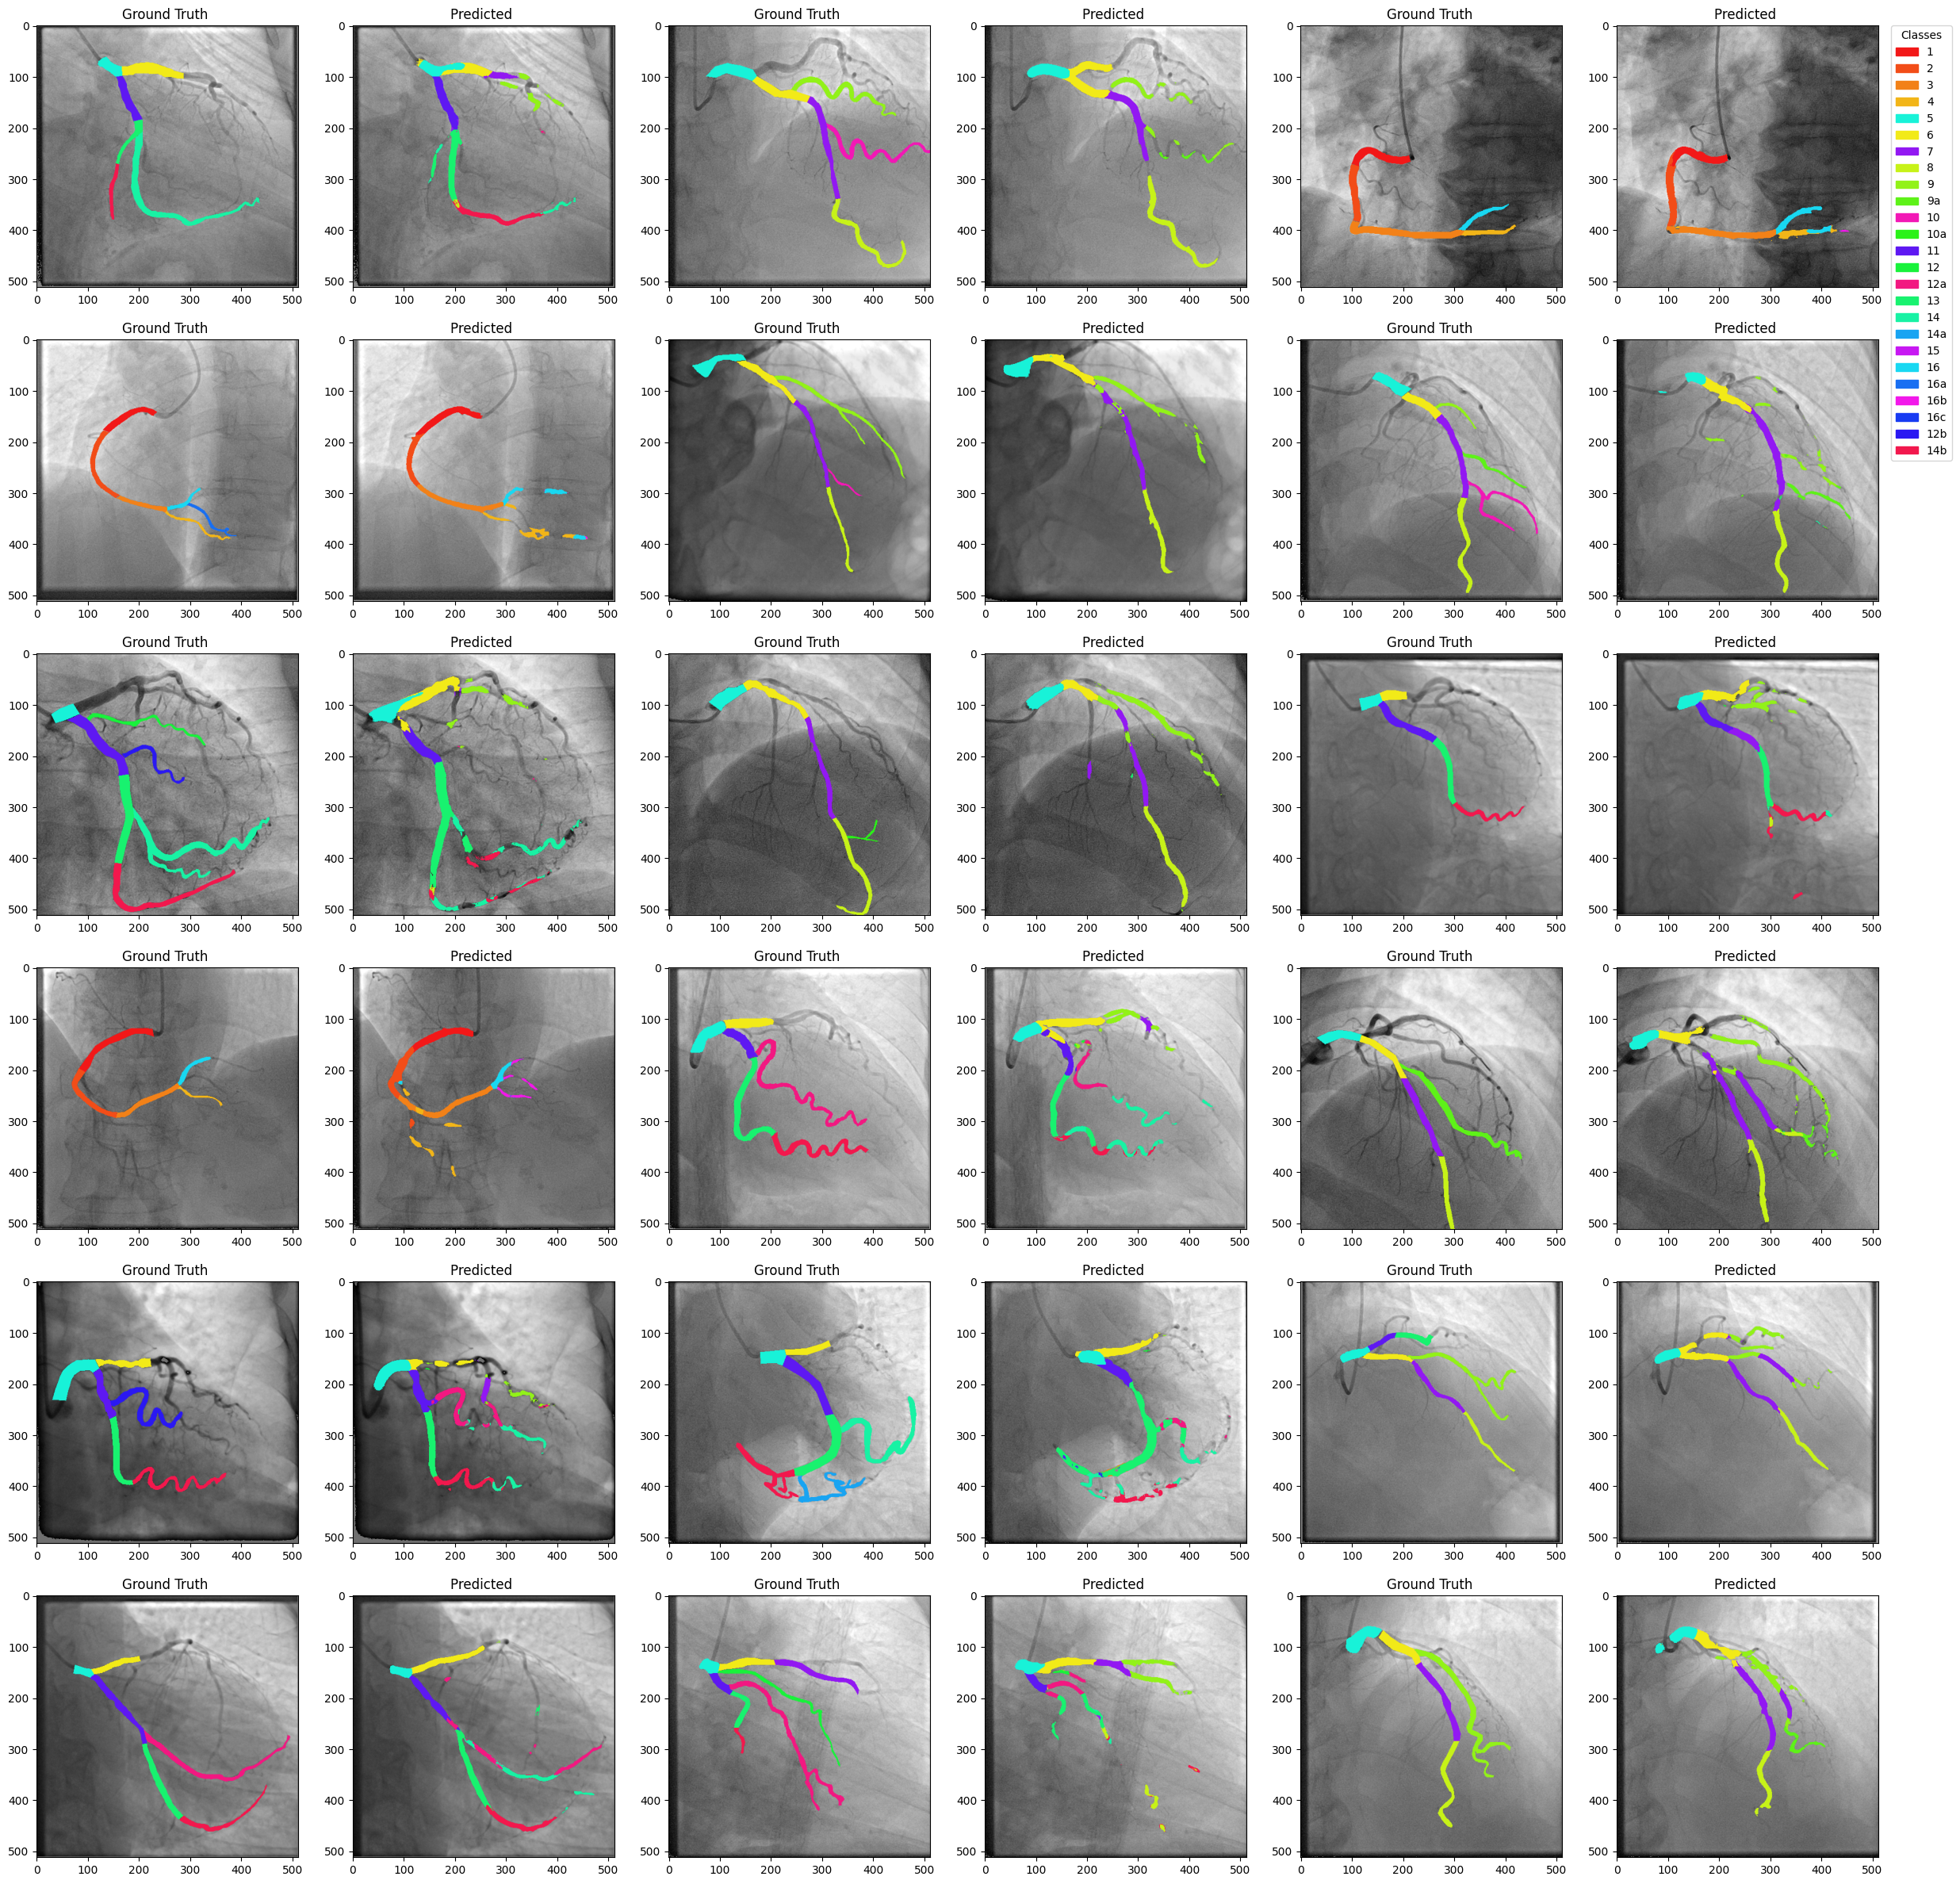

In [7]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)